# Estimating Counts

In [1]:
include("utils.jl"); using .Utils
checkpkgs("Plots", "DataFrames", "Statistics")
using Plots, Statistics

## The Train Problem

In [2]:
include("empiricaldist.jl"); using .EmpiricalDist
hypos = 1:1001
prior = Pmf(1, hypos);

In [3]:
"""Update pmf based on new data."""
function update_train!(pmf, data)
    hypos = pmf.qs
    likelihood = 1 ./ hypos
    impossible = (data .> hypos)
    likelihood[impossible] .= 0
    pmf .*= likelihood
    normalize!(pmf)
end
update_train!(pmf; data) = update_train!(pmf, data) # so we can call update_train!(pmf, data=data)

update_train! (generic function with 2 methods)

In [4]:
data = 60
posterior = copy(prior)
update_train!(posterior, data);

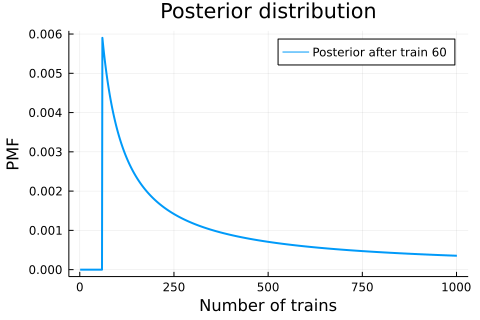

In [5]:
plot(posterior, label="Posterior after train 60",
     xlabel="Number of trains", ylabel="PMF",
     title="Posterior distribution")

In [6]:
maxprob(posterior)

60

In [7]:
sum(posterior.ps .* posterior.qs)

333.6561137141766

In [8]:
mean(posterior)

333.6561137141766

In [9]:
using DataFrames

df = DataFrame("Upper bound"=>[],"Posterior mean"=>[])

for high in [500, 1000, 2000]
    hypos = 1:high
    pmf = Pmf(1, hypos)
    update_train!(pmf, data=60)
    push!(df, (high, mean(pmf)))
end
df

,Upper bound,Posterior mean
,Any,Any
1,500,207.079
2,1000,333.42
3,2000,552.179


In [10]:
using DataFrames

df = DataFrame("Upper bound"=>[],"Posterior mean"=>[])

dataset = [30, 60, 90]

for high in [500, 1000, 2000]
    hypos = 1:high
    pmf = Pmf(1, hypos)
    for data in dataset
        update_train!(pmf, data)
    end
    push!(df, (high, mean(pmf)))
end
df

,Upper bound,Posterior mean
,Any,Any
1,500,151.85
2,1000,164.306
3,2000,171.338


## Power Law Prior

In [11]:
alpha = 1.0
ps = hypos.^(-alpha)
power = Pmf(ps, hypos, name="power law")
normalize!(power);

In [12]:
hypos = 1:1000
uniform = Pmf(1, hypos, name="uniform")
normalize!(uniform)

1000.0

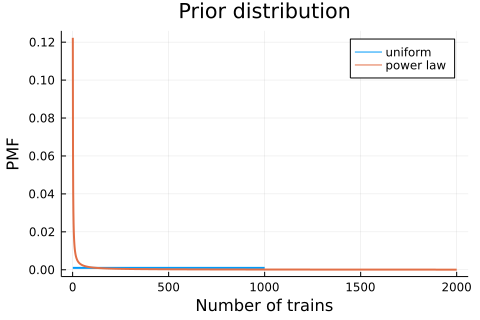

In [13]:
plot(uniform)
plot!(power)
xlabel!("Number of trains")
ylabel!("PMF")
title!("Prior distribution")

In [14]:
dataset = [60]
update_train!(uniform, dataset)
update_train!(power, dataset);

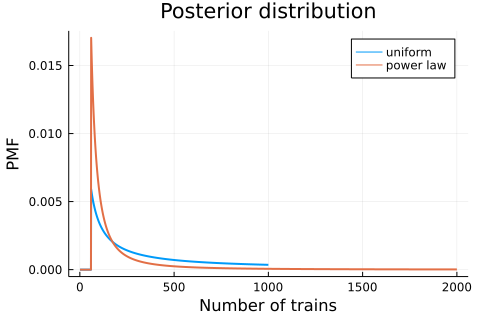

In [15]:
plot(uniform)
plot!(power)
xlabel!("Number of trains")
ylabel!("PMF")
title!("Posterior distribution")

In [16]:
using DataFrames

df = DataFrame("Upper bound"=>[],"Posterior mean"=>[])

dataset = [30, 60, 90]

for high in [500, 1000, 2000]
    hypos = 1:high
    ps = hypos.^(-alpha)
    power = Pmf(ps, hypos)
    for data in dataset
        update_train!(power, data)
    end
    push!(df, (high, mean(power)))
end
df

,Upper bound,Posterior mean
,Any,Any
1,500,130.708
2,1000,133.275
3,2000,133.997


## Credible Intervals

In [17]:
prob_le(power, 100)

0.29374692224957655

In [18]:
# quantile() is defined in empiricaldist, so renaming this one
"""Compute a quantile with the given prob."""
function myquantile(pmf, prob)
    total = 0
    for (q, p) in pairs(pmf)
        total += p
        if total >= prob
            return q
        end
    end
    return nothing
end

myquantile

In [19]:
myquantile(power, 0.5)

113

In [20]:
quantile(power, 0.5)

113

In [21]:
quantile(power, [0.05, 0.95])

2-element Vector{Int64}:
  91
 243

In [22]:
credibleinterval(power, 0.9)

2-element Vector{Int64}:
  91
 243

## The German Tank Problem

## Informative Priors

## Summary

## Exercises

In [23]:
# 5.1
using Distributions

hypos = 1:2000
prior = Pmf(1, hypos)
normalize!(prior);

In [24]:
likelihood1 = pdf.(Binomial.(hypos, 1/365), 2)
likelihood2 = pdf.(Binomial.(hypos, 1/365), 1)
likelihood3 = pdf.(Binomial.(hypos, 1/365), 0);

In [25]:
posterior = prior .* likelihood1 .* likelihood2 .* likelihood3
normalize!(posterior)

0.006758812734080063

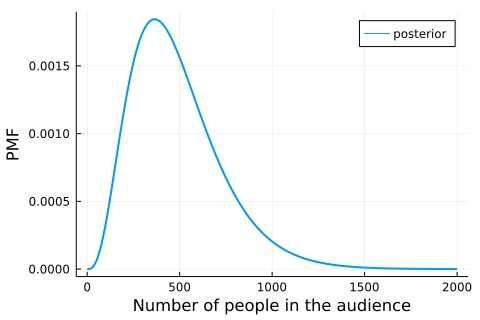

In [26]:
plot(posterior, label="posterior")
xlabel!("Number of people in the audience")
ylabel!("PMF")

In [27]:
mean(posterior)

486.22852304394326

In [28]:
prob_gt(posterior, 1200)

0.011237515568273845

In [29]:
# 5.2
hypos = 4:10
prior = Pmf(1, hypos);

In [30]:
N = hypos
likelihood = (N.-1) ./ N.^2;

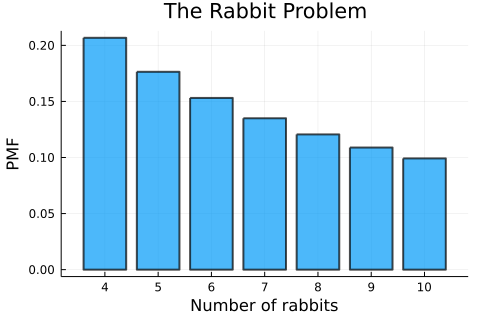

In [31]:
posterior = prior .* likelihood
normalize!(posterior)

bar(posterior, alpha=0.7)
xlabel!("Number of rabbits")
ylabel!("PMF")
title!("The Rabbit Problem")

In [32]:
# 5.3
hypos = 1:3
prior = Pmf(1/3, hypos)
prior

┌───┬──────────┐
│   │    probs │
├───┼──────────┤
│ 1 │ 0.333333 │
│ 2 │ 0.333333 │
│ 3 │ 0.333333 │
└───┴──────────┘


In [33]:
likelihood = hypos
posterior = prior .* likelihood
normalize!(posterior)
posterior

┌───┬──────────┐
│   │    probs │
├───┼──────────┤
│ 1 │ 0.166667 │
│ 2 │ 0.333333 │
│ 3 │      0.5 │
└───┴──────────┘


In [34]:
mean(posterior) / 2

1.1666666666666665

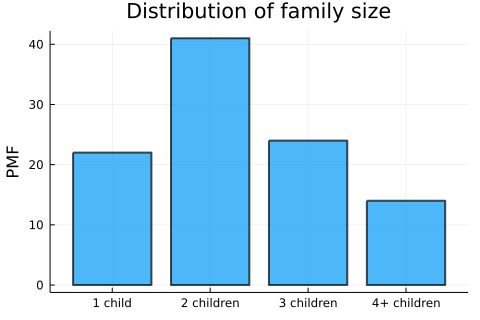

In [35]:
# 5.4
qs = [1, 2, 3, 4]
ps = [22, 41, 24, 14]
prior = Pmf(ps, qs)
bar(prior, alpha=0.7)

xticks!(qs, ["1 child", "2 children", "3 children", "4+ children"])
ylabel!("PMF")
title!("Distribution of family size")

In [36]:
likelihood = qs
posterior = prior .* likelihood
normalize!(posterior)
posterior

┌───┬───────────┐
│   │     probs │
├───┼───────────┤
│ 1 │ 0.0948276 │
│ 2 │  0.353448 │
│ 3 │  0.310345 │
│ 4 │  0.241379 │
└───┴───────────┘


In [37]:
1 - posterior[1]

0.9051724137931034

In [38]:
prob_gt(posterior, 1)

0.9051724137931034

In [39]:
# 5.5
hypos = [200, 2000]
prior = Pmf(1, hypos);

In [40]:
likelihood = 1 ./ prior.qs
posterior = prior .* likelihood
normalize!(posterior)
posterior

┌──────┬───────────┐
│      │     probs │
├──────┼───────────┤
│  200 │  0.909091 │
│ 2000 │ 0.0909091 │
└──────┴───────────┘
